In [2]:
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import sys
from skimage.transform import resize
from skimage.measure import label, regionprops
from skimage.segmentation import clear_border
from skimage.util import crop
from skimage.io import imsave, imread
from skimage.morphology import (erosion, dilation, opening, closing, white_tophat)
from skimage.morphology import disk
from skimage.io import imsave
import time


sys.path.append('../src')
import unet7

In [3]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_cols = 1392
img_rows = 1040
epochs = 1 #100 1001
batch_size = 80
smooth = 1.
start_lr = 1e-4
target_width = 256
target_height = 256

upscale_factor_width = img_cols / target_width
upscale_factor_height = img_cols / target_height

In [4]:
import neptune.new as neptune
from neptune.new.types import File

run = neptune.init(
    project="mlid/DeepUTI",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI0Y2JmNWIzMS1hYmMyLTQ2ODUtODVmNy02MWJiNzBlODQ0M2MifQ==",  
)

https://app.neptune.ai/mlid/DeepUTI/e/DUTI-2


Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs.neptune.ai/you-should-know/what-can-you-log-and-display#hardware-consumption


Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [5]:
parameters = {
    "img_cols": 1392,
    "img_rows": 1040,
    "epochs": 1,
    "batch_size": 80,
    "smooth": 1.,
    "start_lr": 1e-4,
    "target_width": 256,
    "target_height": 256,
    "upscale_factor_width": img_cols/ target_width,
    "upscale_factor_height": img_rows/ target_height
}

run["model/parameters"] = parameters

In [6]:
def checkDir(directory):
    if not os.path.exists(directory):
        os.makedirs(directory)
        
def read_imgs(dir, img_rows, img_cols):
    images = [f for f in os.listdir(dir) if f.endswith('.tif')]
    imgs = np.ndarray((len(images), img_rows, img_cols, 1), dtype=np.float)
    for idx, img in enumerate(images):
        #print(idx)
        img = imread(os.path.join(dir, img), as_gray=True)
        img = np.expand_dims(img, axis=-1)
        imgs[idx] = img
    return imgs

def test_model(model, x, y_true, log_dir):
    y_true = np.rint(y_true[0])
    y_pred = model.predict(x)
    y_pred = np.rint(y_pred[0])
    x = x[0]

    plt.figure(figsize=(40,8))
    plt.subplot(1, 3, 1)
    plt.title('Input')
    plt.imshow(np.squeeze(x))

    plt.subplot(1, 3, 2)
    plt.title('Prediction')
    plt.imshow(np.squeeze(y_pred))

    plt.subplot(1, 3, 3)
    plt.title('Ground truth')
    plt.imshow(np.squeeze(y_true))

    plt.savefig(os.path.join(log_dir,'ground_truth_e{}.png'.format('test')), bbox_inches='tight', dpi=300)
    plt.show()

In [7]:
runningTime = time.strftime('%b-%d-%Y_%H-%M')
model_dir = os.path.join('..','data')
log_dir = os.path.join(model_dir, 'Practice','logs',"{}".format(runningTime))
checkDir(log_dir)

In [8]:
# Add additional parameters
run["model/parameters/runningTime"] = runningTime
run["model/parameters/model_dir"] = model_dir
run["model/parameters/log_dir"] = log_dir

# Update parameters. For example, after triggering early stopping
# run["model/parameters/n_epochs"] = epoch

In [9]:
# Update parameters. For example, after triggering early stopping
# run["model/parameters/upscale_factor_height"] = img_rows/ target_height

In [10]:
from neptune.new.integrations.tensorflow_keras import NeptuneCallback

In [11]:
# Training


tensorboard = TensorBoard(log_dir=os.path.join(model_dir,"{}".format(runningTime)))
#tensorboard = TensorBoard(log_dir=log_dir)

callbacksList = [tensorboard,NeptuneCallback(run=run)]

#model = unet7.get_unet(img_cols, img_rows)
model = unet7.Unet(target_width, target_width, nclasses=1)

#model.compile(optimizer=Adam(lr=5e-5), loss=unet7.dice_coef_loss, metrics=[unet7.dice_coef])
model.compile(optimizer=Adam(learning_rate=start_lr), loss=unet7.dice_loss, metrics=[unet7.dice_coeff])

model.summary()
#print("start tensorboard, cmd: tensorboard --logdir=\""+os.path.join(model_dir,"{}".format(runningTime)+"\""))
print("start tensorboard, cmd: tensorboard --logdir=\""+os.path.join(log_dir+"\""))

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['image_input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                               

In [12]:
data = np.load('../data/full_res_patch_dataset_sample.npz')
training_imgs=data['training_imgs']
training_masks=data['training_masks']
test_imgs=data['test_imgs']
test_masks=data['test_masks']
del data

In [13]:
# You can upload image from the disc
# run["val/conf_matrix"].upload("confusion_matrix.png")

# You can also upload plot objects directly
# run["val/roc_curve"].upload(plt_fig_roc)

# from neptune.new.types import File

# # You can upload image series from the disc
# for image_path in misclassified_images_paths:
#     run["valid/misclassified"].log(File(image_path))

# # You can also upload plot objects directly
# for epoch in range(params["iterations"]):
#     plt_fig = get_histogram()
#     run["train/distribution"].log(plt_fig)

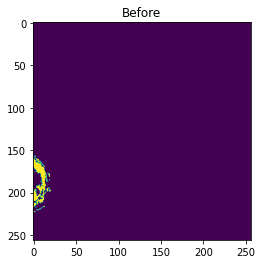

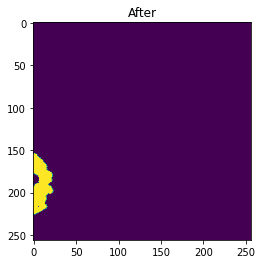

In [14]:
# improve the masks
test = training_masks[0]
plt.figure()
plt.title('Before')
plt.imshow(np.squeeze(test))
plt.savefig(os.path.join(log_dir,"before_dilation.png"),bbox_inches='tight', dpi=300)
run["model/samples/before_dilation"].upload(os.path.join(log_dir,"before_dilation.png"))

footprint = disk(3)
test = dilation(np.squeeze(test), footprint)


plt.figure()
plt.title('After')
plt.imshow(np.squeeze(test))
plt.savefig(os.path.join(log_dir,"after_dilation.png"),bbox_inches='tight', dpi=300)
run["model/samples/after_dilation"].upload(os.path.join(log_dir,"after_dilation.png"))

In [15]:
# run["model/parameters/before_dilation"].upload(os.path.join(log_dir,"before_dilation.png"))
# run["model/parameters/after_dilation"].upload(os.path.join(log_dir,"after_dilation.png"))

In [21]:
for i in range(training_masks.shape[0]):
    training_masks[i,:,:,0] = dilation(np.squeeze(training_masks[i,:,:,0]), footprint)

for i in range(test_masks.shape[0]):
    test_masks[i,:,:,0] = dilation(np.squeeze(test_masks[i,:,:,0]), footprint)

In [16]:
# Data augmentation

img_gen_args = dict(samplewise_center=True,
                     samplewise_std_normalization=True,
                     #rotation_range=30,
                     #width_shift_range=0.15,
                     #height_shift_range=0.15,
                     vertical_flip=True,
                     horizontal_flip=True,
                     #zoom_range=[0.8,1.2],
                     #brightness_range=[0.8,1.2],
                     fill_mode='nearest')

mask_gen_args = dict(samplewise_center=False,
                     samplewise_std_normalization=False,
                     #rotation_range=15,
                     #width_shift_range=0.15,
                     #height_shift_range=0.15,
                     vertical_flip=True,
                     horizontal_flip=True,
                     preprocessing_function=np.rint,
                     #zoom_range=[0.8,1.2],
                     fill_mode='nearest')

image_datagen = ImageDataGenerator(**img_gen_args)
mask_datagen = ImageDataGenerator(**mask_gen_args)

seed = 123
image_datagen.fit(training_imgs, augment=True, seed=seed)
mask_datagen.fit(training_masks, augment=True, seed=seed)

image_generator = image_datagen.flow(training_imgs, batch_size=batch_size, seed=seed)
mask_generator = mask_datagen.flow(training_masks, batch_size=batch_size, seed=seed)

gen_train = zip(image_generator, mask_generator)


img_gen_args_test = dict(samplewise_center=True,
                     samplewise_std_normalization=True,
                     #rotation_range=30,
                     #width_shift_range=0.15,
                     #height_shift_range=0.15,
                     #vertical_flip=True,
                     #horizontal_flip=True,
                     #zoom_range=[0.8,1.2],
                     #brightness_range=[0.8,1.2],
                     fill_mode='nearest')

mask_gen_args_test = dict(samplewise_center=False,
                     samplewise_std_normalization=False,
                     #rotation_range=15,
                     #width_shift_range=0.15,
                     #height_shift_range=0.15,
                     #vertical_flip=True,
                     #horizontal_flip=True,
                     preprocessing_function=np.rint,
                     #zoom_range=[0.8,1.2],
                     fill_mode='nearest')

image_datagen_test = ImageDataGenerator(**img_gen_args_test)
mask_datagen_test = ImageDataGenerator(**mask_gen_args_test)

seed = 123
image_datagen_test.fit(test_imgs, augment=True, seed=seed)
mask_datagen_test.fit(test_masks, augment=True, seed=seed)

image_generator_test = image_datagen_test.flow(test_imgs, batch_size=batch_size, seed=seed)
mask_generator_test = mask_datagen_test.flow(test_masks, batch_size=batch_size, seed=seed)

gen_test = zip(image_generator_test, mask_generator_test)

In [17]:
history = model.fit(
        gen_train,
        batch_size = batch_size,
        steps_per_epoch=training_imgs.shape[0] // epochs, #200, 40
        epochs=epochs,
        validation_freq = 1,
        validation_data=gen_test, validation_steps=1,
        callbacks=callbacksList)



10/10 [==============================] - 12s 1s/step - loss: 0.9657 - dice_coeff: 0.0343 - val_loss: 0.9636 - val_dice_coeff: 0.0364


In [18]:
run["model/evaluation/loss"] = history.history['loss']
run["model/evaluation/dice_coeff"] = history.history['dice_coeff']
run["model/evaluation/val_loss"] = history.history['val_loss']
run["model/evaluation/val_dice_coeff"] = history.history['val_dice_coeff']

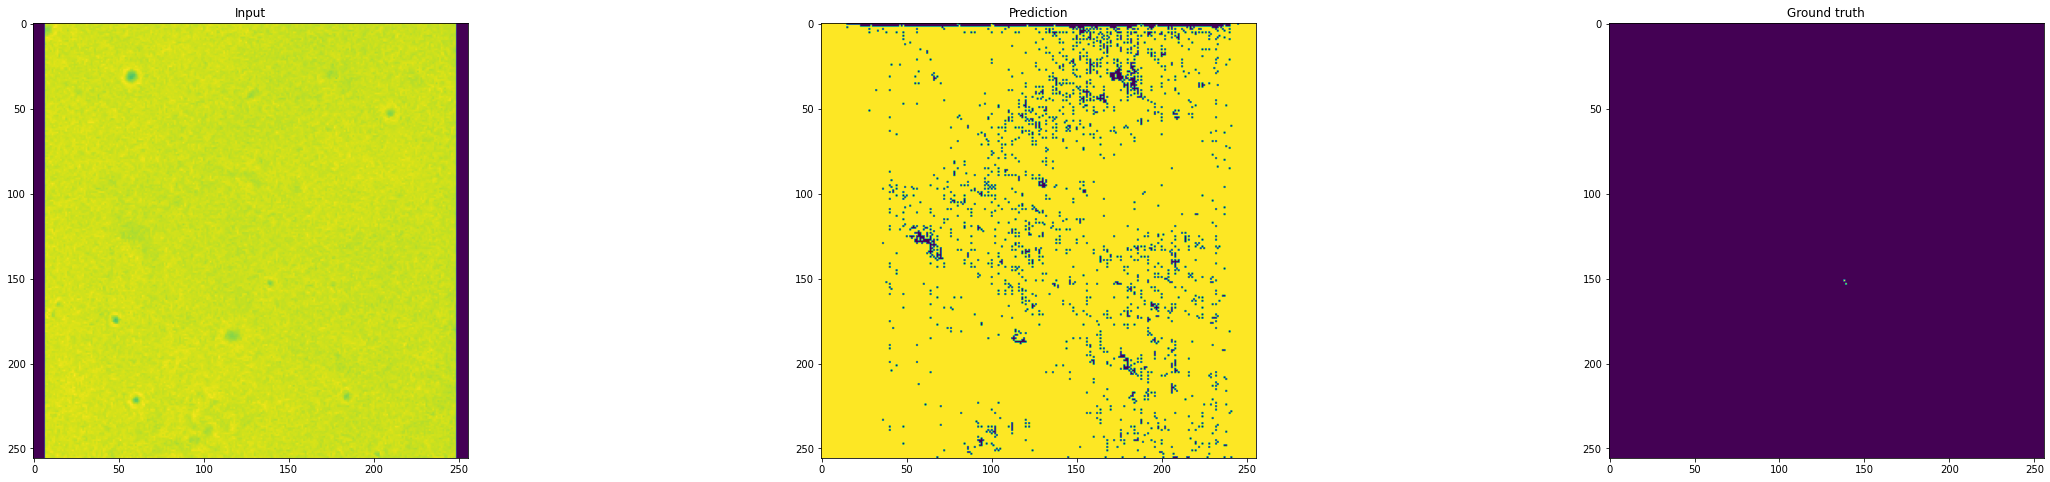

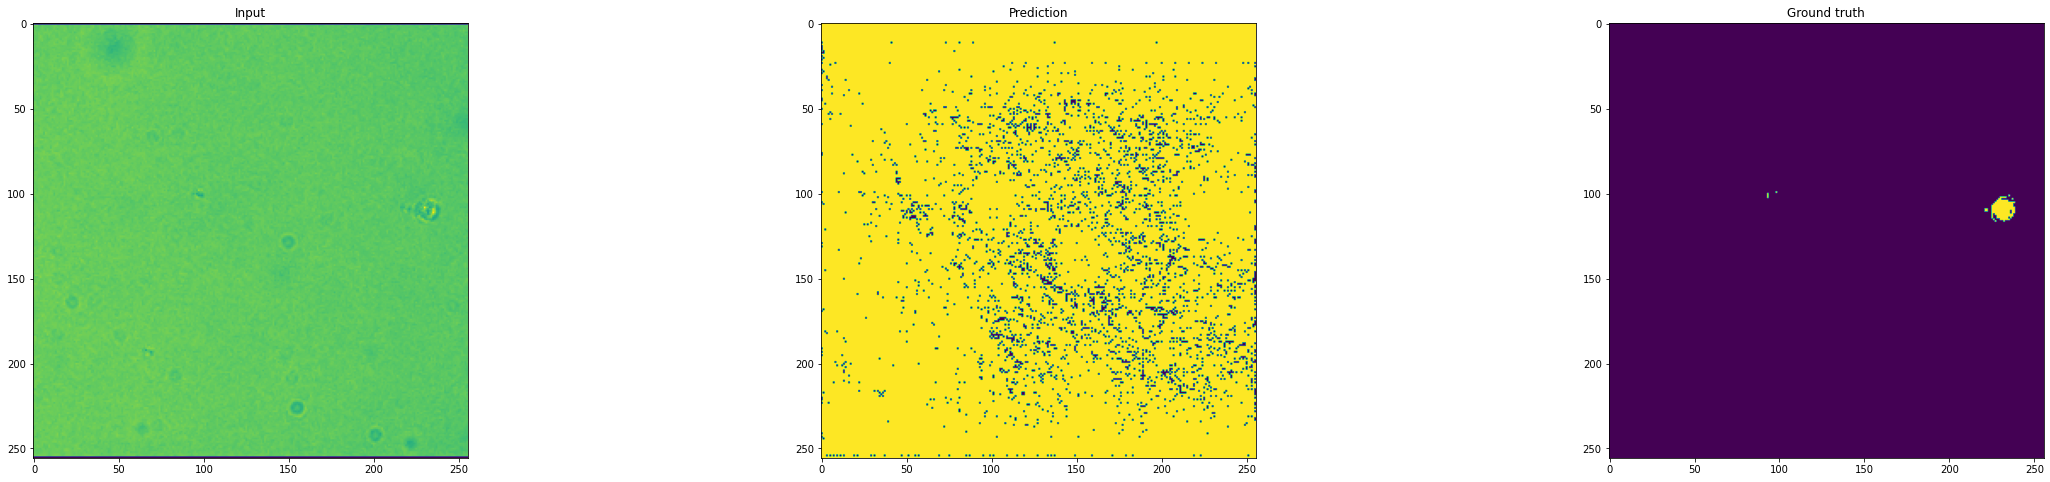

In [19]:
img_exmp = image_generator.next()
mask_exmp = mask_generator.next()
test_model(model, img_exmp, mask_exmp, log_dir)

test_img_exmp = image_generator_test.next()
test_mask_exmp = mask_generator_test.next()
test_model(model, test_img_exmp, test_mask_exmp, log_dir)

In [20]:
run["model/evaluation/test_output"].upload(os.path.join(log_dir,"ground_truth_etest.png"))

In [24]:
model.save(os.path.join(log_dir,runningTime+'.h5'))

run["model/saved_model"].upload(os.path.join(log_dir,runningTime+'.h5'))

In [23]:
from tensorflow import keras

reloaded_model = keras.models.load_model(os.path.join(log_dir,runningTime+'.h5'),custom_objects = {"dice_loss": unet7.dice_loss, "dice_coeff": unet7.dice_coeff})
reloaded_model.summary()

Model: "Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image_input (InputLayer)       [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 8)  80          ['image_input[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 8)  32         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                               

In [25]:
run.stop()

Shutting down background jobs, please wait a moment...
Done!


Waiting for the remaining 3 operations to synchronize with Neptune. Do not kill this process.


All 3 operations synced, thanks for waiting!
Explore the metadata in Neptune UI:
https://app.neptune.ai/mlid/DeepUTI/e/DUTI-2
